# Model Inference and Evaluation

In [2]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp 

import torch
from torch.utils.data import DataLoader
import torchmetrics

from segmentation_dataset import SegmentationDataset


### Check Running Environment

In [3]:
# Check if notebook being run in Colab or locally  
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
print (f'Running in Colab: {IN_COLAB}')

# Check if GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using ", DEVICE)

Running in Colab: False
Using  cuda


### Load Data

In [4]:
if IN_COLAB:
    pass
else:
    test_data_path = 'data/processed/test'

test_dataset = SegmentationDataset(path_name=test_data_path)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Setup Model

In [5]:
model = smp.FPN(
    encoder_name='se_resnext50_32x4d', 
    encoder_weights='imagenet', 
    classes=6, 
    activation='sigmoid',
)
model.to(DEVICE)

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): Identity()
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (se_module): SEModule(
          (

### Load Saved Weights

In [6]:
model.load_state_dict(torch.load('models/FPN_epochs_50_crossentropy_state_dict.pth'))

<All keys matched successfully>

### Evaluate Model

In [7]:
pixel_accuracies = []
intersection_over_unions = []
metric_iou = torchmetrics.JaccardIndex(num_classes=6, task='multiclass').to(DEVICE)

with torch.no_grad():  # No need to track gradients for evaluation
    for data in test_dataloader:
        inputs, outputs = data
        ground_truth = outputs.to(torch.float32) 
        pred = model(inputs.to(DEVICE).float()) # Forward pass
        predicted_class = torch.max(pred, 1)[1]  
        ground_truth = ground_truth.to(DEVICE)
        correct_pixels = (ground_truth == predicted_class).sum().item() # Count of correctly predicted pixels
        total_pixels = ground_truth.size(1) * ground_truth.size(2)  
        pixel_accuracies.append(correct_pixels / total_pixels)

        iou = metric_iou(predicted_class.float(), ground_truth).item()
        intersection_over_unions.append(iou)



In [8]:
# Print results
print(f"Median Pixel Accuracy: {np.median(pixel_accuracies) * 100 }")
print(f"Median IoU: {np.median(intersection_over_unions) * 100 }")


Median Pixel Accuracy: 81.552734375
Median IoU: 29.87763285636902


### Get a random image and display

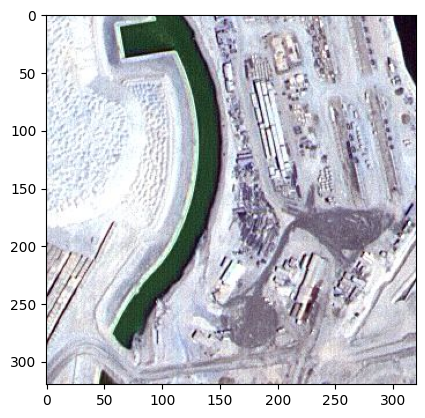

In [9]:
image_test, mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)))


### Evaluate

In [10]:
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

In [11]:
output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape

(320, 320)

In [12]:
# use at least one pixel for each class for both images
required_range = list(range(6))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3
output_cpu[0, 4] = 4
output_cpu[0, 5] = 5

mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3
mask[0, 0, 4] = 4
mask[0, 0, 5] = 5

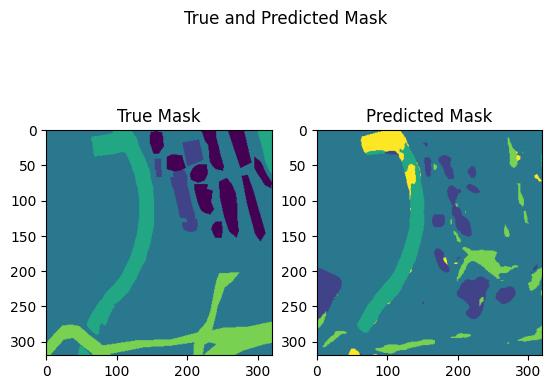

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()